In [167]:
# 代码运行环境
%load_ext watermark
%watermark -p torch,numpy,sklearn -v -m

CPython 3.6.1
IPython 6.0.0

torch 0.1.12_2
numpy 1.12.1
sklearn 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.1.0 (clang-802.0.38)
system     : Darwin
release    : 16.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.metrics as metrics
import numpy as np

## 数据分布的概念
- $P(X)$
    - 本质上就是一个函数，值域(Range)固定在 [0, 1]。定义域及映射决定了这个「分布」 
    - 就其一般形式，$X$ 只要是一个集合即可。机器学习中常用的就是 $\mathbb{R}^N$ 即 N 维数组

### 简单的二分类数据分布

In [3]:
class0_data = np.random.rand(200, 2)
class1_data = np.random.rand(200, 2) + 3

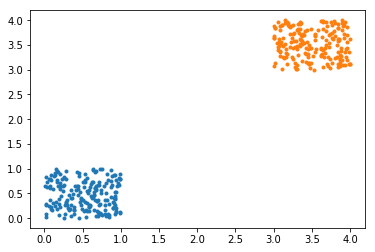

In [4]:
plt.plot(class0_data[:, 0], class0_data[:, 1], '.', class1_data[:, 0], class1_data[:, 1], '.');

上面这个例子是来自 $\mathbb{R}^2$ 的两类数据的「分布」，即 $P(X|y=0)$ 及 $P(X|y=1)$

## Discriminative vs Generative model

Generative Model（以下简称 GM）的典型例子是朴素贝叶斯，通过 GM 可以计算 $P(X, y)$ 的联合分布。Discriminative Model（以下简称DM）的典型例子是 Logistic Regression，其只能直接得到 $P(y|X)$。
- 对 GM 来说，得到 $P(X|y)$ 其实也就意味着得到了联合分布 $P(X, y)$，反之亦然。因为先验分布 $P(y)$ 往往很容易统计或者知道。
  - 得到 $P(X|y)$ 之后，通过贝叶斯公式即可得到 $P(y|X) = \frac{P(X|y)P(y)}{\sum_k P(X|y_k)P(Y_k)}$，$k$ 为 $y$ 的类别数
- 而对 DM 来说，得到 $P(y|X)$ 并没有办法通过概率公式反推联合分布 $P(X,y)$，因为 $P(X)$ 对高维输入来说往往难以通过记数进行准确估计

GM 相当于有更丰富的输入分布信息，因此 GM 可以对输入进行采样，得到有意义的输入，比如在 $P(X|y=1)$ 中采样得到一个典型的「正例」样本。但这也对模型提出了更多的要求和假设。

> "one should solve the [classification] problem directly and never solve a more general problem as an intermediate step [such as modeling p(xly)]." -- Vapnik

References:
- Pluskid, Discriminative Modeling vs Generative Modeling. http://freemind.pluskid.org/machine-learning/discriminative-modeling-vs-generative-modeling/
- Andrew Y. Ng and Michael I. Jordan. 2002. On discriminative vs. generative classifiers: A comparison of logistic regression and naive bayes. In T. G. Dietterich, S. Becker, & Z. Ghahramani, eds. Advances in neural information processing systems 14. MIT Press, 841–848.

上面的二类数据分布看起来很好区分，因为两类数据的概率分布几乎没有「重叠」。事实上只要两类数据的概率分布不是完全重叠，他们还是可以有一定区分力的。

In [9]:
def truncated_norm(lower, upper, mu, sigma):
    a = (lower - mu) / sigma
    b = (upper - mu) / sigma
    return stats.truncnorm(a, b, loc=mu, scale=sigma)

real_data = truncated_norm(0, 1, 0.5, 0.2).rvs(1000)
noise_data = stats.uniform(loc=0, scale=1).rvs(1000)

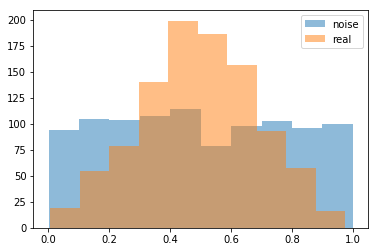

In [12]:
plt.hist(noise_data, alpha=0.5, label='noise');
plt.hist(real_data, alpha=0.5, label='real');
plt.legend();

可以看到真实的分布（假设为正例）在 0.5 附近有更高的概率，因此可以设计一个简单的分类器，在 0.5 附近的点返回 1

In [30]:
def dummy_classify(x):
    return np.abs(x - 0.5) < 0.2

In [31]:
y_pred = dummy_classify(np.concatenate((real_data, noise_data)))
y_true = [1] * len(real_data) + [0] * len(noise_data)

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
accuracy_score(y_true, y_pred)

0.64800000000000002

可以看到，这样一个分类器也能获得一个比随机好的效果。

## Generative Adversarial Nets (GANs)

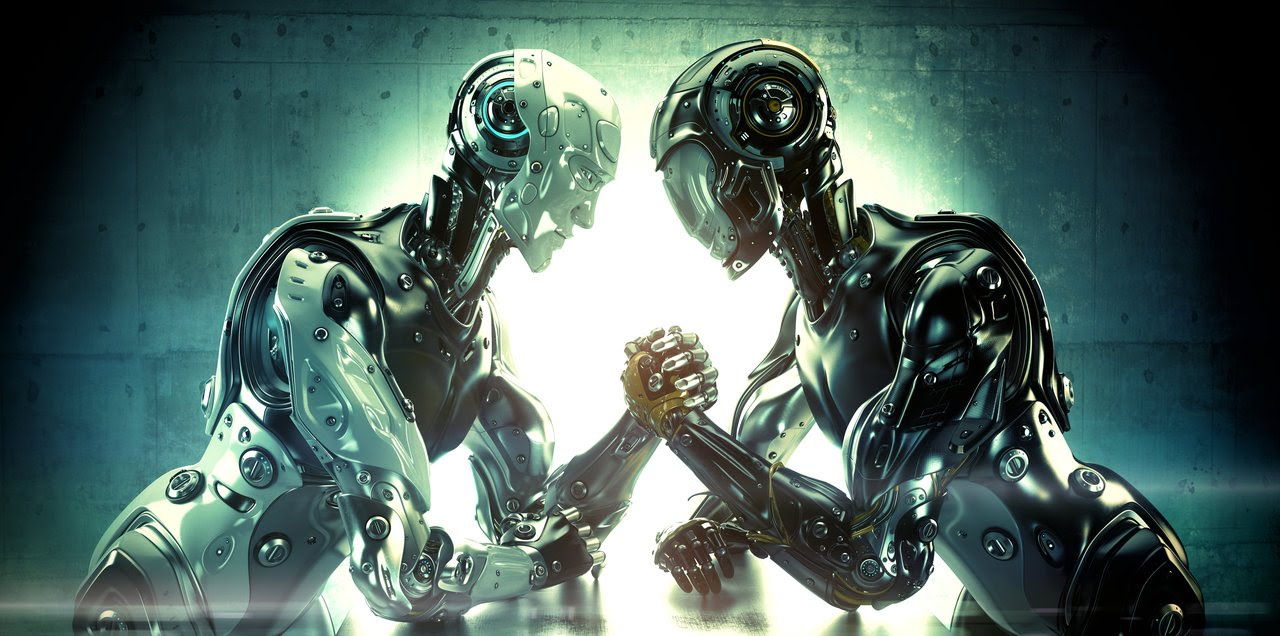
Photo from https://sites.google.com/site/nips2016adversarial/

GANs 的思想是让一个 DM 和一个 GM 进行对抗。其整体优化目标是:
    
$$ \min_G\max_D V(D, G) = E_{x \sim P_{data}(x)}[\log D(x)] + E_{z \sim P_z(z)}[\log (1 - D(G(z))]$$

- 这个优化目标可以拆成两个部分来看：
    - 对 DM 来说，其输入来自两个分布，即 $x \sim P_{data}(x)$ 及 $z \sim P_z(z)$
        - 如果只看 $x \sim P_{data}(x)$，那么 DM 面对的就是一个普通的二分类问题
        - $z \sim P_z(z)$ 是 GM 的输入分布，GM 会对该输入进行变换，变换之后的数据分布会和 $P_{data}$ 很像，即起到「伪造」的效果。而 DM 的另一个目标就是识别出这种「伪造」
    - 对 GM 来说，目标就是「伪造」出和 $P_{data}$ 很像的分布。伪造的方法是从一个先验分布 $P_z$ 中采样数据，进行变换之后使之很像 $P_{data}$
    
[1] 中提供了一个很形象的图来表示这个过程，其中 Input Generator 对应为在 $P_z$ 中采样，由于 $P_z$ 完全是一个先验分布（如 Uniform Distribution)，其提供的数据是毫无「意义」的。而 GM 的作用就是「化腐朽为神奇」，将无意义的输入「伪造」成一个有意义的模式，让 DM 难以识别。

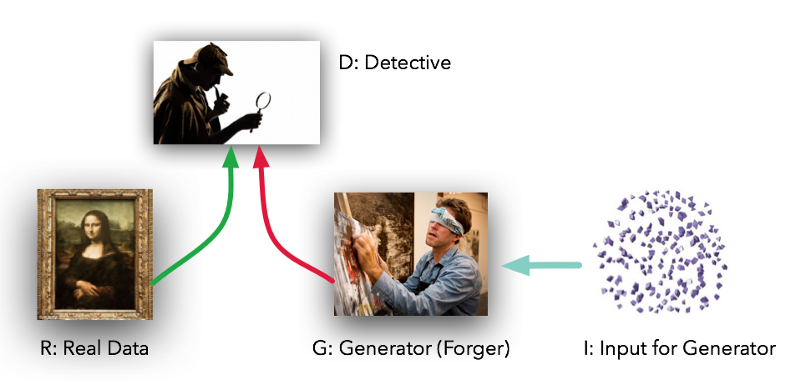

这个过程也可以想像成古董鉴定家和古董造假家的博弈过程。鉴定家一开始很容易就鉴定出造假的古董，造假家为了避免被识破，努力提高自己的姿势水平。随着造假家水平的提高，鉴定家也逐渐变得真假莫辨。

References:
- [1] Dav Nag, Generative Adversarial Networks (GANs) in 50 lines of code (PyTorch) https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f


### PyTorch 中的实现

下面在 PyTorch 中实现一个简单的 GANs。

In [31]:
# 产生一组数据，模型不知道数据怎么产生的。
data_num = 1000
# x ~ [-1, 1]
circle_x = (np.random.rand(data_num) - 0.5) * 2
# y ~ sqrt(1 - x^2)
# to generate a circle
circle_y = np.random.choice([-1, 1], data_num) * np.sqrt(1 - circle_x ** 2)

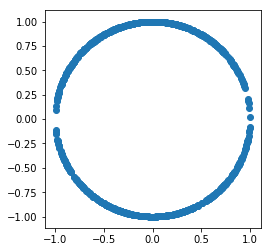

In [29]:
fig, axes = plt.subplots(1)
axes.scatter(circle_x, circle_y)
axes.set_aspect('equal')

In [59]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [52]:
# A straight-forward 3-layer NN
# Output: Sigmoid (probability)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.params = nn.Sequential(nn.Linear(input_dim, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 1),
                                    nn.Sigmoid())
        
    def forward(self, input):
        return self.params(input)

In [55]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()        
        self.params = nn.Sequential(nn.Linear(input_dim, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, output_dim),
                                    nn.Tanh())
    def forward(self, input):
        return self.params(input)

In [56]:
dm = Discriminator(2)
gm = Generator(2, 2)

In [64]:
sample_data = Variable(torch.rand(5, 2), volatile=True)

In [65]:
# DM will output probabilty
dm(sample_data)

Variable containing:
 0.5157
 0.5147
 0.5220
 0.5231
 0.5180
[torch.FloatTensor of size 5x1]

In [66]:
# GM will output faked 2-D data
gm(sample_data)

Variable containing:
-0.1271 -0.0186
-0.0752  0.0523
-0.1021 -0.0316
-0.0713  0.0369
-0.0977  0.0171
[torch.FloatTensor of size 5x2]

In [99]:
real_data = torch.FloatTensor(np.hstack((circle_x[:, np.newaxis], circle_y[:, np.newaxis])))
print(real_data.size())

torch.Size([1000, 2])


In [101]:
criterion = nn.BCELoss() # binary cross entropy loss
d_optimizer = torch.optim.Adam(dm.parameters())
g_optimizer = torch.optim.Adam(gm.parameters())

!注意，这里模型训练可能需要运行比较久

In [146]:
num_epochs = 2000
k = 5

d_loss = []
g_loss = []
for epoch in range(num_epochs):
    # Optimize DM
    for d_step in range(k):
        dm.zero_grad()
        real = Variable(real_data)
        d_preds = dm(real)
        loss = criterion(d_preds, Variable(torch.ones(data_num)))        
        loss.backward()
        
        g_input = Variable(torch.rand(data_num, 2))
        # !important
        # need to detach here, we only want to optimize DM in this loop
        g_fake = gm(g_input).detach()
        d_fake_preds = dm(g_fake)
        loss = criterion(d_fake_preds, Variable(torch.zeros(data_num)))
        if d_step == k - 1:
            d_loss.append(loss.data[0])
        loss.backward()
        d_optimizer.step()
        
    # Optimize GM
    gm.zero_grad()
    g_input = Variable(torch.rand(data_num, 2))
    g_fake = gm(g_input)
    d_fake_preds = dm(g_fake)
    # Notice the difference here, GM wants to trick DM
    loss = criterion(d_fake_preds, Variable(torch.ones(data_num)))
    g_loss.append(loss.data[0])
    loss.backward()
    g_optimizer.step()

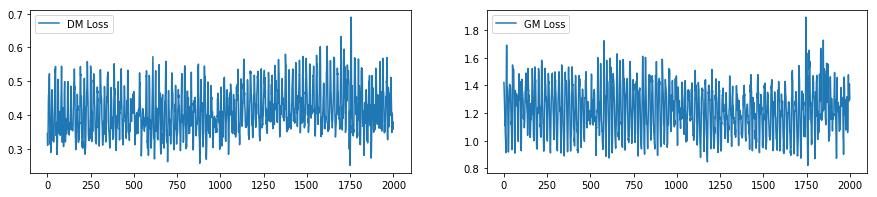

In [147]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
axes[0].plot(range(len(d_loss)), d_loss, label='DM Loss')
axes[0].legend()
axes[1].plot(range(len(g_loss)), g_loss, label='GM Loss')
axes[1].legend();

训练之后，来看一下 G 现在生成的东西

In [148]:
g_input = Variable(torch.rand(data_num, 2), volatile=True)
g_fake = gm(g_input)

In [157]:
gm_init = Generator(2, 2)
g_fake_init = gm_init(g_input)

In [158]:
g_input_data = g_input.data.numpy()
g_fake_data = g_fake.data.numpy()
g_fake_init_data = g_fake_init.data.numpy()

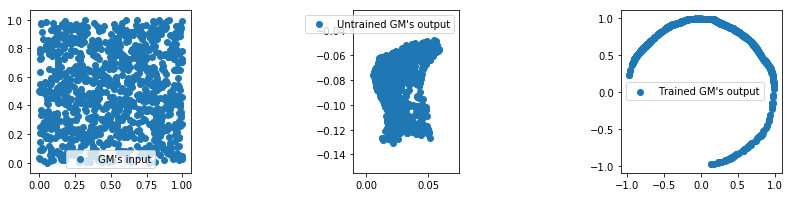

In [164]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
axes[0].scatter(g_input_data[:, 0], g_input_data[:, 1], label="GM's input")
axes[1].scatter(g_fake_init_data[:, 0], g_fake_init_data[:, 1], label="Untrained GM's output")
axes[2].scatter(g_fake_data[:, 0], g_fake_data[:, 1], label="Trained GM's output")
for ax in axes:
    ax.set_aspect('equal')
    ax.legend()